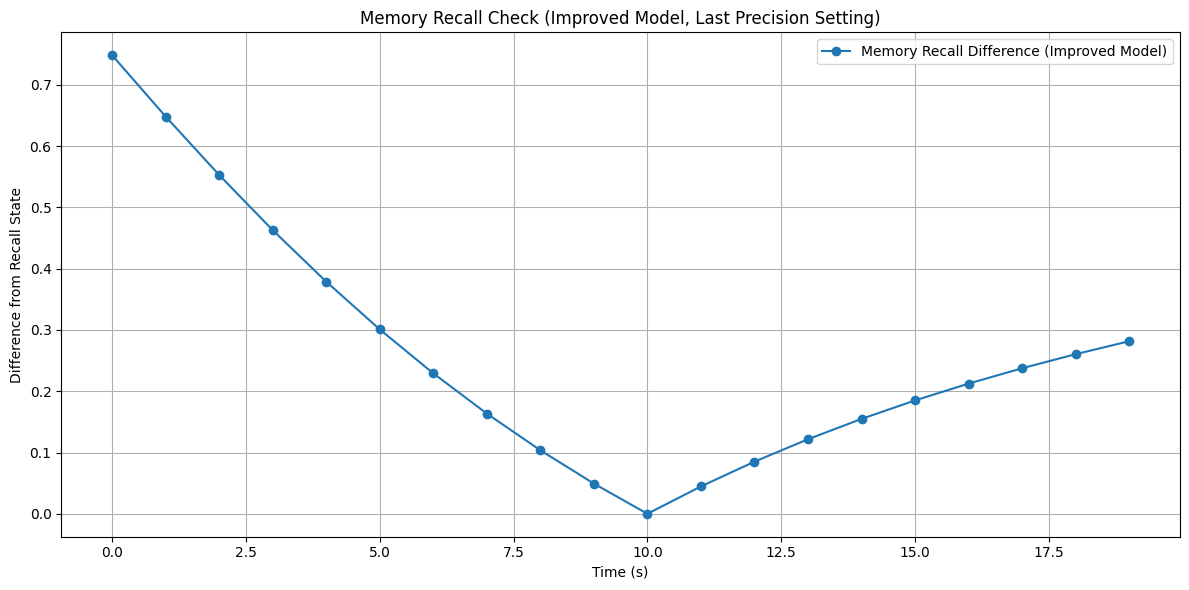

Baseline Model Results:
Precision: 30 digits -> Runtime: 0.014581 s, Memory usage change: 107.27 KB
Precision: 50 digits -> Runtime: 0.013918 s, Memory usage change: 8.54 KB
Precision: 100 digits -> Runtime: 0.019236 s, Memory usage change: 20.60 KB

Improved Model Results:
Precision: 30 digits -> Runtime: 0.045665 s, Memory usage change: 108.09 KB
Precision: 50 digits -> Runtime: 0.056732 s, Memory usage change: 3.98 KB
Precision: 100 digits -> Runtime: 0.087239 s, Memory usage change: 21.68 KB


In [1]:
import time
from mpmath import mp, mpf
import matplotlib.pyplot as plt
import tracemalloc

# Function to simulate LTC neurons (baseline)
def simulate_ltc(time_steps, dt, neurons_per_layer, parallel_chains, decay_factors, precision=50):
    """
    Simulates a liquid time constant (LTC) neuron over a given number of time steps.

    Args:
        time_steps (int): The number of time steps to simulate.
        dt (float): The time step size.
        neurons_per_layer (int): The number of neurons in each layer.
        parallel_chains (int): The number of parallel chains to simulate.
        decay_factors (list of float): The decay factors for each neuron.
        precision (int, optional): The precision for the simulation. Defaults to 50.

    Returns:
        tuple: A tuple containing:
            - neuron_states (list of list of list of mp.mpf): The states of the neurons at each time step.
            - runtime (float): The time taken to run the simulation.
    """
    mp.dps = precision
    # Initialize neuron states
    neuron_states = [
        [[mp.mpf('0') for _ in range(neurons_per_layer)] for _ in range(parallel_chains)] for _ in range(time_steps)
    ]

    start_time = time.time()
    for t in range(1, time_steps):
        for chain in range(parallel_chains):
            for neuron in range(neurons_per_layer):
                if neuron == 0:
                    # First neuron integrates input signal
                    dstate = (1 / decay_factors[neuron]) * (mp.mpf('1.0') - neuron_states[t - 1][chain][neuron]) * dt
                else:
                    dstate = (1 / decay_factors[neuron]) * (
                        neuron_states[t - 1][chain][neuron - 1] - neuron_states[t - 1][chain][neuron]
                    ) * dt
                neuron_states[t][chain][neuron] = neuron_states[t - 1][chain][neuron] + dstate
    runtime = time.time() - start_time
    return neuron_states, runtime

# Improved LTC model (just a placeholder for demonstration)
# For example, add a nonlinear term: dstate = ( ... ) * (neuron_states[t-1][chain][neuron])^0.5
def simulate_ltc_improved(time_steps, dt, neurons_per_layer, parallel_chains, decay_factors, precision=50):
    mp.dps = precision
    neuron_states = [
        [[mp.mpf('0') for _ in range(neurons_per_layer)] for _ in range(parallel_chains)] for _ in range(time_steps)
    ]

    start_time = time.time()
    for t in range(1, time_steps):
        for chain in range(parallel_chains):
            for neuron in range(neurons_per_layer):
                prev_state = neuron_states[t - 1][chain][neuron]
                if neuron == 0:
                    dstate = (1 / decay_factors[neuron]) * ((mp.mpf('1.0') - prev_state) * (prev_state+mp.mpf('1'))**mp.mpf('0.5')) * dt
                else:
                    input_signal = neuron_states[t - 1][chain][neuron - 1]
                    dstate = (1 / decay_factors[neuron]) * ((input_signal - prev_state) * (mp.mpf('1')+prev_state)**mp.mpf('0.5')) * dt
                neuron_states[t][chain][neuron] = prev_state + dstate
    runtime = time.time() - start_time
    return neuron_states, runtime

def memory_recall(neuron_states, recall_timestep):
    # Compare state at recall_timestep with states at all other timesteps for chain=0
    time_steps = len(neuron_states)
    neurons_per_layer = len(neuron_states[0][0])
    recall_state = neuron_states[recall_timestep][0]
    differences = []
    for t in range(time_steps):
        diff = [abs(float(recall_state[i]) - float(neuron_states[t][0][i])) for i in range(neurons_per_layer)]
        differences.append(sum(diff))
    return differences

### Benchmark Parameters ###
time_steps = 20
dt = mp.mpf('1.0')
neurons_per_layer = 5
parallel_chains = 5
decay_factors = [mp.mpf('10.0'), mp.mpf('100.0'), mp.mpf('1000.0'), mp.mpf('2000.0'), mp.mpf('5000.0')]
precisions = [30, 50, 100]  # Test three different precision levels
recall_timestep = 10

### Run Benchmarks ###
baseline_runtimes = []
improved_runtimes = []

# Start tracemalloc for memory usage tracking
tracemalloc.start()

for prec in precisions:
    # Snapshot before baseline
    snapshot_before = tracemalloc.take_snapshot()
    baseline_states, base_time = simulate_ltc(time_steps, dt, neurons_per_layer, parallel_chains, decay_factors, precision=prec)
    snapshot_after = tracemalloc.take_snapshot()
    baseline_stats = snapshot_after.compare_to(snapshot_before, 'lineno')
    baseline_mem = sum([stat.size_diff for stat in baseline_stats])
    baseline_runtimes.append((prec, base_time, baseline_mem))

    # Snapshot before improved
    snapshot_before = tracemalloc.take_snapshot()
    improved_states, imp_time = simulate_ltc_improved(time_steps, dt, neurons_per_layer, parallel_chains, decay_factors, precision=prec)
    snapshot_after = tracemalloc.take_snapshot()
    improved_stats = snapshot_after.compare_to(snapshot_before, 'lineno')
    improved_mem = sum([stat.size_diff for stat in improved_stats])
    improved_runtimes.append((prec, imp_time, improved_mem))

tracemalloc.stop()

### Plotting memory recall just for the last run (improved model at highest precision) ###
differences = memory_recall(improved_states, recall_timestep)
time_vector = [t * float(dt) for t in range(time_steps)]

plt.figure(figsize=(12,6))
plt.plot(time_vector, differences, marker='o', label='Memory Recall Difference (Improved Model)')
plt.title('Memory Recall Check (Improved Model, Last Precision Setting)')
plt.xlabel('Time (s)')
plt.ylabel('Difference from Recall State')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Print benchmark results ###
print("Baseline Model Results:")
for prec, rt, mem in baseline_runtimes:
    print(f"Precision: {prec} digits -> Runtime: {rt:.6f} s, Memory usage change: {mem/1024.0:.2f} KB")

print("\nImproved Model Results:")
for prec, rt, mem in improved_runtimes:
    print(f"Precision: {prec} digits -> Runtime: {rt:.6f} s, Memory usage change: {mem/1024.0:.2f} KB")
